<a href="https://colab.research.google.com/github/mneedham/data-science-training/blob/master/02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In this notebook we're going to explore the citation dataset. We should already have installed py2neo, pandas, and matplotlib when setting up our environment, so let's get those imported:

In [1]:
from neo4j import GraphDatabase
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
driver = GraphDatabase.driver("bolt://data-science-training-neo4j", auth=("neo4j", "admin"))        
print(driver.address)

Address(host='data-science-training-neo4j', port=7687)


## What's in our database?

Now we can run the following query to check how many nodes our database contains:

In [3]:
with driver.session() as session:
    result = session.run("CALL db.schema()")
    for row in result:
        print(f"nodes: {row['nodes']}")
        print(f"relationships: {row['relationships']}")

nodes: [<Node id=-3 labels={'Venue'} properties={'indexes': [], 'name': 'Venue', 'constraints': ['CONSTRAINT ON ( venue:Venue ) ASSERT venue.name IS UNIQUE']}>, <Node id=-1 labels={'Article'} properties={'indexes': ['title,abstract'], 'name': 'Article', 'constraints': ['CONSTRAINT ON ( article:Article ) ASSERT article.index IS UNIQUE']}>, <Node id=-2 labels={'Author'} properties={'indexes': [], 'name': 'Author', 'constraints': ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE']}>]
relationships: [<Relationship id=-5 nodes=(<Node id=-2 labels={'Author'} properties={'indexes': [], 'name': 'Author', 'constraints': ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE']}>, <Node id=-2 labels={'Author'} properties={'indexes': [], 'name': 'Author', 'constraints': ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE']}>) type='CO_AUTHOR_EARLY' properties={}>, <Relationship id=-1 nodes=(<Node id=-1 labels={'Article'} properties={'indexes': ['title,abstract'], 'n

If we run `CALL db.schema()` in the Neo4j Browser (http://localhost:7474/browser/), we'll see the following visualisation:

<img src="images/data-science-training.png" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels?

In [4]:
result = {"label": [], "count": []}
with driver.session() as session:
    for row in session.run("CALL db.labels()"):
        label = row["label"]
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


We can visualize the counts using matplotlib with the following code:

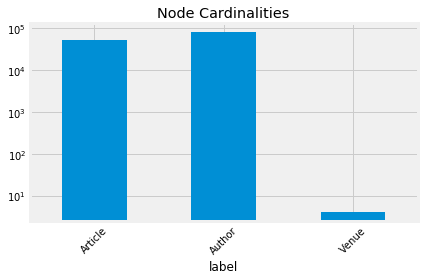

In [5]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And what types of relationships do we have?

In [8]:
result = {"relType": [], "count": []}
with driver.session() as session:
    for row in session.run("""
    CALL db.relationshipTypes()
YIELD relationshipType
WHERE not relationshipType starts with "CO_AUTHOR"
RETURN relationshipType
    """):
        relationship_type = row["relationshipType"]
        query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["relType"].append(relationship_type)
        result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


We can visualize the counts using matplotlib with the following code:

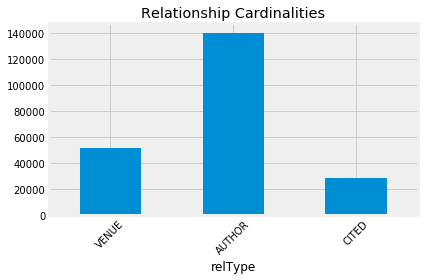

In [9]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.

In [17]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
WITH article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
WHERE citationsGiven > 0 AND citationsReceived > 0
RETURN article, author, citationsGiven, citationsReceived,venue
ORDER BY rand()
LIMIT 25
"""

with driver.session() as session:
    result = session.run(exploratory_query)

# dict(result.single())    
    
pd.DataFrame([dict(record) for record in result])

,article,author,citationsGiven,citationsReceived,venue
0,Performance debugging in the large via mining ...,Yingnong Dang,6,8,international conference on software engineering
1,2 nd SEMAT workshop on a general theory of sof...,Paul Ralph,1,1,international conference on software engineering
2,LaSSIE: a knowledge-based software information...,Bruce W. Ballard,4,15,Communications of The ACM
3,Evaluation of safety-critical software,S.-P. Kwan,1,8,Communications of The ACM
4,Detecting memory leaks through introspective d...,Santosh Pande,3,1,international conference on software engineering
5,An Abductive Logic Programming Architecture fo...,Francesca Toni,3,7,Lecture Notes in Computer Science
6,Secure communications in ATM networks,Nathan Hillery,1,1,Communications of The ACM
7,Employment and salaries of recent doctorates i...,Catherine Gaddy,2,1,Communications of The ACM
8,WhoseFault: automatic developer-to-fault assig...,Francisco Servant,6,1,international conference on software engineering
9,The Inconsistency in Rough Set Based Rule Gene...,Guoyin Wang,1,2,Lecture Notes in Computer Science


Let's look into the citation data more closely. We'll write a query that returns the number of citations that each article has, and then create a distribution of those counts using pandas `describe` function:

In [18]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

with driver.session() as session:
    result = session.run(query)

citation_df = pd.DataFrame([dict(record) for record in result])
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


Most articles are being cited very few times. 99% of articles have 1 citation or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data;

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xscale'

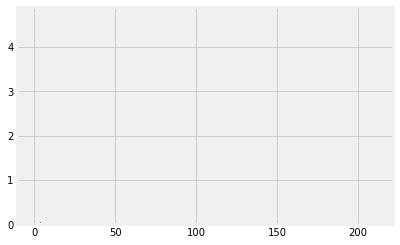

In [21]:
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise

* Can you create a similar chart showing the articles that cite the most other papers? Note that you'll only need to do a slight tweak of the Cypher query to do this. 
* What about a distribution of the number of articles published by authors?

Keep the results of these exercises handy as they form part of the Check your understanding quiz at the end of this module.